# Obtaining Spectra

This notebook demonstrates the process used to select the initial dataset of approximately 1000 solar-type stars from the entire dataset of APOGEE spectra.

## Obtaining the `allstar` File

We can start with the `allStar-dr17-synspec_rev1.fits` file, which is publicly available from the SDSS [here](https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits).

This file contains measured properties of stars in the APOGEE catalogue and can be used to select the sample.

In [1]:
from astropy.table import Table

allstars = 'data/allStar-dr17-synspec_rev1.fits'
tbl = Table.read(allstars)

## Selecting Targets

Stars with a signal-to-noise ratio (SNR) below `250` are excluded from the search.

In [2]:
snr_filter = tbl['SNR'] > 250
print('Num stars: %i' %sum(snr_filter))

Num stars: 170183


We now plot the remaining stars on a temperature versus surface gravity to visualize the remaining stars.

Since we are also looking for solar-type stars, we want to select for stars near the Sun on this plot, which is shown using the red box.

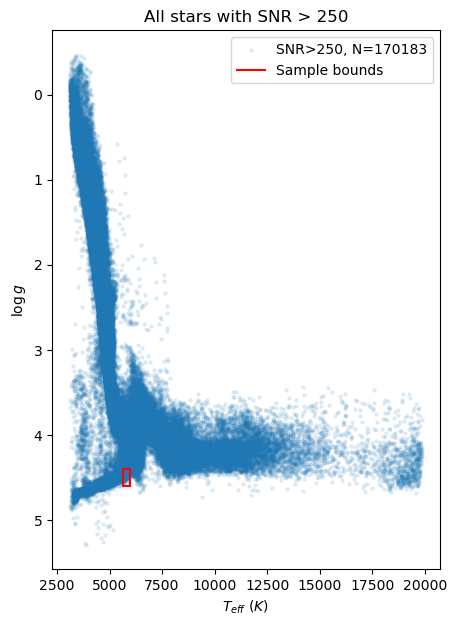

In [3]:
import matplotlib.pyplot as plt

_ = plt.figure(figsize=(5,7))
plt.title('All stars with SNR > 250')
plt.scatter(tbl['TEFF'][snr_filter], tbl['LOGG'][snr_filter], 
            s=5, alpha=0.1, label='SNR>250, N=%i' %sum(snr_filter))
plt.gca().invert_yaxis()

teff = 5800
teff_spread = 150
logg = 4.5
logg_spread = 0.1

plt.plot([
        teff + teff_spread,
        teff + teff_spread,
        teff - teff_spread,
        teff - teff_spread,
        teff + teff_spread
    ], 
    [
        logg + logg_spread,
        logg - logg_spread,
        logg - logg_spread,
        logg + logg_spread,
        logg + logg_spread
    ], c='r', label='Sample bounds')
plt.xlabel('$T_{eff}$ ($K$)')
plt.ylabel('$\log g$')
_ = plt.legend()

We can now select only stars in this box and ensure we have enough to make a sample of the desired size.

Note we also include a filter based on the BP and RP magnitude, since it was later determined that there were a few outliers in the aspect.

In [4]:
import numpy as np

star_filter = np.array(
    (snr_filter) &
    (tbl['TEFF'] > teff - teff_spread) &
    (tbl['TEFF'] < teff + teff_spread) &
    (tbl['LOGG'] > logg - logg_spread) &
    (tbl['LOGG'] < logg + logg_spread) &
    (tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'] < 1.0 )
)

print('Num stars: %i' %sum(star_filter))

Num stars: 1254


1254 stars is plenty, so we can now plot these stars on the same temperature verses surface gravity diagram to make sure the selection worked as we expect.

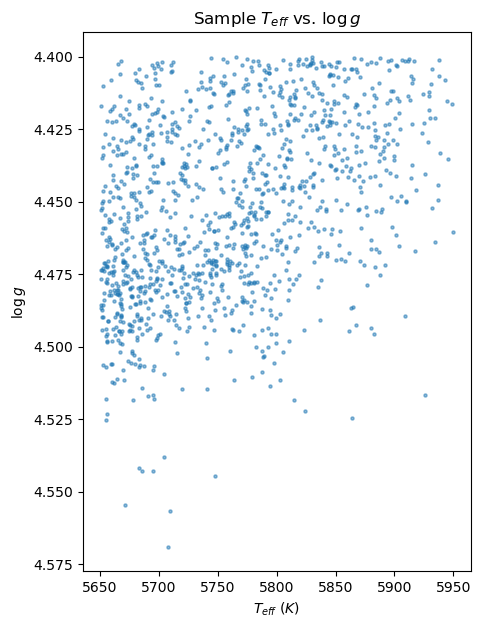

In [5]:
_ = plt.figure(figsize=(5,7))
plt.scatter(tbl['TEFF'][star_filter], tbl['LOGG'][star_filter], 
            s=5, alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('$T_{eff}$ ($K$)')
plt.ylabel('$\log g$')
_ = plt.title('Sample $T_{eff}$ vs. $\log g$')

We can now plot these stars in a variety of other ways to make sure our sample is not significantly biased in any particular way.

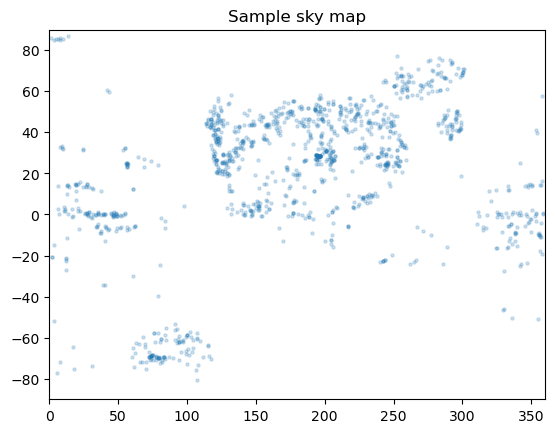

In [6]:
_ = plt.scatter(tbl['RA'][star_filter], tbl['DEC'][star_filter], s=5, alpha=0.2)
plt.xlim(0, 360)
plt.ylim(-90, 90)
_ = plt.title('Sample sky map')

Here we also plot the bounds used in previous work to make sure our sample is not too different.

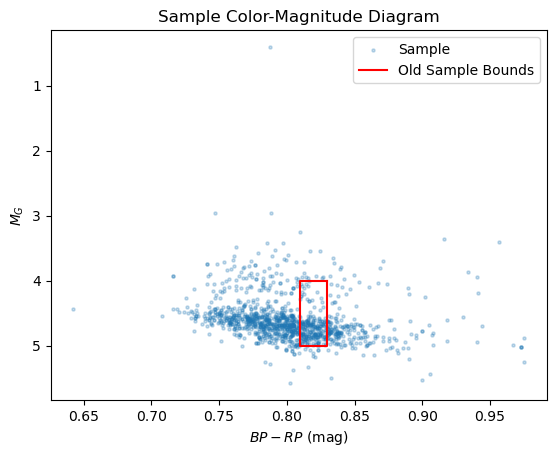

In [7]:
_ = plt.scatter(tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'][star_filter] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'][star_filter], 
            tbl['GAIAEDR3_PHOT_G_MEAN_MAG'][star_filter] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'][star_filter])+5, 
            s=5, alpha=0.25, label='Sample')
plt.plot([0.82+0.01, 0.82+0.01, 0.82-0.01, 0.82-0.01, 0.82+0.01], [4,5,5,4,4], c='r', label='Old Sample Bounds')
plt.gca().invert_yaxis()
plt.xlabel('$BP - RP$ (mag)')
plt.ylabel('$M_G$')
plt.legend()
_ = plt.title('Sample Color-Magnitude Diagram')

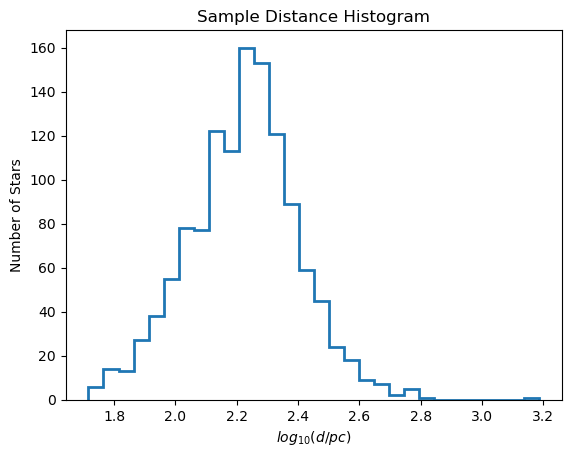

In [8]:
_ = plt.hist(np.log10(tbl['GAIAEDR3_R_LO_PHOTOGEO'][star_filter]),bins=30, lw=2, histtype='step')
plt.xlabel(r'$log_{10}(d/pc)$')
plt.ylabel('Number of Stars')
_ = plt.title('Sample Distance Histogram')

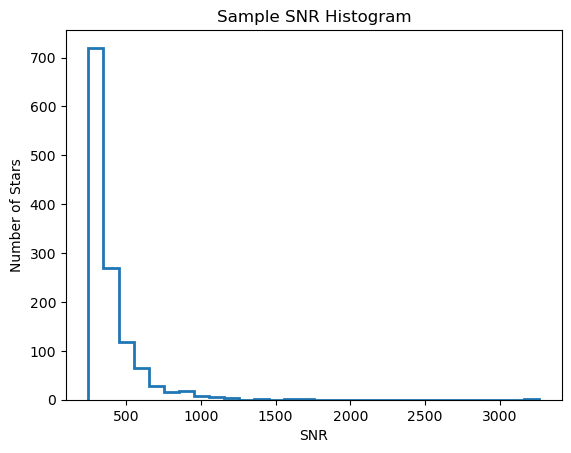

In [9]:
_ = plt.hist(tbl['SNR'][star_filter],bins=30, histtype='step', lw=2)
plt.xlabel('SNR')
plt.ylabel('Number of Stars')
_ = plt.title('Sample SNR Histogram')

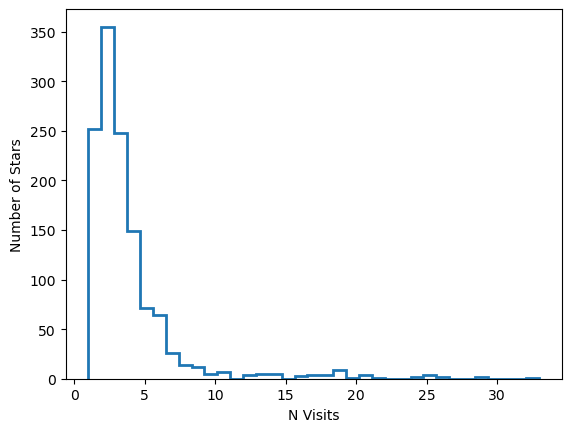

In [10]:
plt.hist(tbl['NVISITS'][star_filter],bins=35, histtype='step', lw=2)
plt.xlabel('N Visits')
_ = plt.ylabel('Number of Stars')

## Considerations for Selecting Targets

If you are selecting a dataset other than the one shown here. There are some
key details you should consider while selecting spectra to use:

- The spectra should all be from very similar stars. ALIAS relies heavily on
  similarities between spectra to identify unusual features. If you have a very
  large dataset, consider splitting it into peices to be analyzed separately
  based on stellar characteristics.
- ALIAS is designed to function well on datasets of 1000 stars. It should also
  work well on significantly larger datasets, but be cautious when using
  significantly smaller datasets.

## Downloading Spectra

Now that we are happy with our sample, we can construct urls for the stars' spectra and write them to a file.

In [11]:
telescopes = tbl['TELESCOPE'][star_filter]
fields = tbl['FIELD'][star_filter]
files = tbl['FILE'][star_filter]

urls = np.array(
    [
        'https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/%s/%s/%s' %atts
        for atts in zip(telescopes, fields, files)
    ]
)

with open('data/sample_star_urls', 'w') as f:
    for url in urls:
        f.write(url + '\n')

with open('data/sample_star_files', 'w') as f:
    for file in files:
        f.write(file + '\n')

This command will individually download each spectrum and place it in the current directory:

<code>mkdir data/spectra
cd data/spectra
xargs -a ../sample_star_urls -d '\n' -n 1 -t curl -JO</code>